# Using continous / categorical / transition matrices to get recommendations / Selective Box Cox

In [59]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt 
import math
from ipynb.fs.full.Utils import createKDeplot, loadDataFrames, dropFeaturesWithNoVariance
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import dask_ml.cluster
from ipynb.fs.full.Pipeline import removeConstantFeatures, applyBoxCoxAllFeatures, centerAndScale, applyEuclideanDistance, getIndexAndVector, applyBoxCoxFeatures,applyJaccard, getEuclideanJaccardDf 

In [60]:
df = pd.read_csv("./data/unified/05-allDataContinousCategoricalTransition.csv")
df = df.drop(columns=['Unnamed: 0', 'index'])

In [61]:
continousFeatures,_ = getEuclideanJaccardDf(df)

In [62]:
continousFeatures = continousFeatures.sort_values('id')
continousFeatures.id = continousFeatures.id.astype('int64')
continousFeatures = continousFeatures.set_index('id')

In [63]:
continousFeatures

,0,1,10,100,1000,1001,1002,1003,1004,1005,...,997,998,999,acousticness,danceability,energy,liveness,speechiness,tempo,valence
id,,,,,,,,,,,,,,,,,,,,,
23,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.001400,0.494,0.756,0.1640,0.0432,133.337,0.589
105,0.185185,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000458,0.582,0.744,0.0405,0.0336,133.344,0.674
118,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.011236,0.016200,0.614,0.755,0.0831,0.0276,92.622,0.645
120,0.029412,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.001040,0.319,0.807,0.1310,0.0388,118.097,0.601
292,0.013889,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.195000,0.496,0.527,0.1380,0.0339,155.932,0.283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6002496,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.347000,0.509,0.537,0.0805,0.0384,170.030,0.311
6002497,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.300000,0.725,0.583,0.0665,0.0427,79.984,0.762
6002498,0.000000,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.019700,0.399,0.787,0.0685,0.0499,117.089,0.572


In [64]:
from sklearn.feature_selection import VarianceThreshold

# Create a VarianceThreshold feature selector
sel = VarianceThreshold(threshold=0.001)

# Fit the selector to normalized head_df
sel.fit(continousFeatures / continousFeatures.mean())

# Create a boolean mask
mask = sel.get_support()

# Apply the mask to create a reduced dataframe
df = continousFeatures.loc[:, mask]


In [65]:
df = removeConstantFeatures(df)
df= applyBoxCoxFeatures(df, ['speechiness', 'acousticness', 'liveness', 'valence'])
df = centerAndScale(df)

In [66]:
X = df.values.tolist()

In [67]:
numClusters = 3

km = dask_ml.cluster.KMeans(n_clusters=numClusters)
km.fit(X)

KMeans(n_clusters=3)

### Elbow criterion method

In [68]:

from sklearn.cluster import KMeans

import seaborn as sns
from matplotlib import pyplot as plt
sse = {}
for k in range(1,12):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_

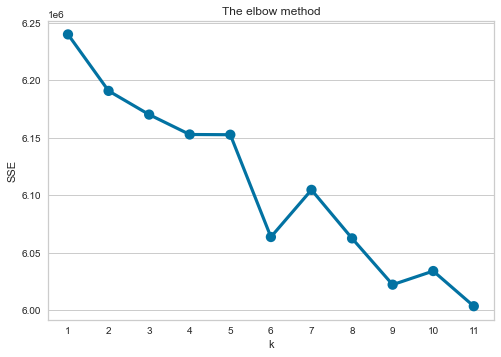

In [69]:
plt.title('The elbow method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

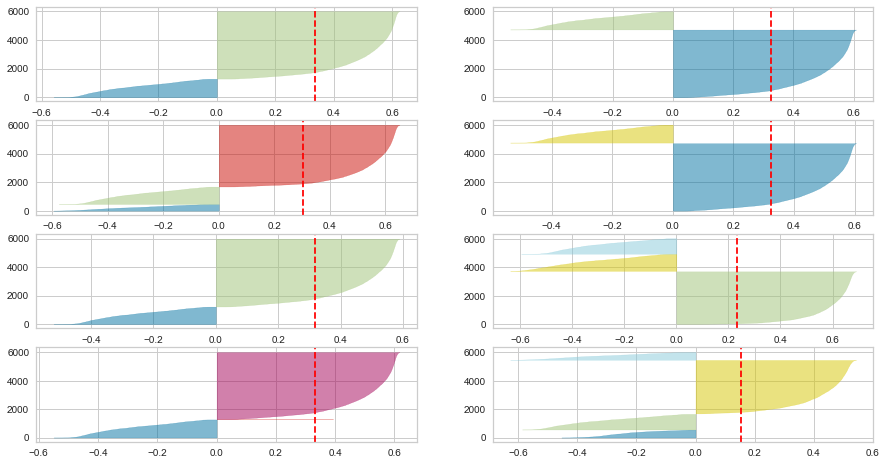

In [58]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)